In [1]:
import xsimlab as xs
import math

In [2]:
@xs.process
class Biomass:
    B_vars = xs.group('biomass')
    dB = xs.variable(intent='inout',default=0)
    B = xs.variable(intent='inout',default=1)
    
    #we can actually safely use run_step because of the cycle ordering?
    def run_step(self):
        self.dB = sum(self.B_vars)
        self.B += self.dB

#jsut some processes to have a longer cycle
@xs.process
class FracInterceptedLight:
    leaf_area = xs.variable(global_name='leaf_area',intent='in')
    intercepted_light = xs.variable(intent='out')
    ext_coeff = xs.variable(default=0.8)
    
    def run_step(self):
        self.intercepted_light = 1-math.exp(-self.ext_coeff*self.leaf_area)

@xs.process
class LeafAreaAnnual:
    leaf_area = xs.global_ref('leaf_area',intent='out')
    prev_dB = xs.foreign(Biomass, 'dB')

    pl = xs.variable(default = 0.002)
    init_leaf_area = xs.variable(default = 0.01)
    
    def initialize(self):
        self.leaf_area = self.init_leaf_area
    
    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        self.leaf_area += self.pl*self.prev_dB*dt

#this process actually adds some to 'biomass' group
@xs.process
class LightLimitedPlantGrowth:
    frac_light = xs.foreign(FracInterceptedLight,"intercepted_light")
    
    light_efficiency = xs.variable(default=3)
    biomass_growth = xs.variable(intent='out',groups='biomass')
    
    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        #wrongfully assuming 
        self.biomass_growth = self.light_efficiency*self.frac_light
    
@xs.process
class InitialBiomass:
    initial = xs.variable(default=1)
    biomass = xs.foreign(Biomass,'B',intent='out')
    
    def initialize(self):
        self.biomass = self.initial
    
@xs.process
class BiomassDeath:
    biomass = xs.foreign(Biomass,"B")
    death_rate = xs.variable(default=0.0005)
    biomass_death = xs.variable(intent='out',groups='biomass')
    
    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        self.biomass_death = -self.biomass*self.death_rate*dt

In [3]:
model = xs.Model(
    {
        
        'f_light':FracInterceptedLight,
        'initial':InitialBiomass,
        'leaf_area':LeafAreaAnnual,
        'growth':LightLimitedPlantGrowth,
        'death':BiomassDeath,
        'biomass':Biomass,
    }
)

[('biomass', 'dB')] [('biomass', 'dB')] dB prev_dB
[('biomass', 'B')] [('biomass', 'B')] B biomass


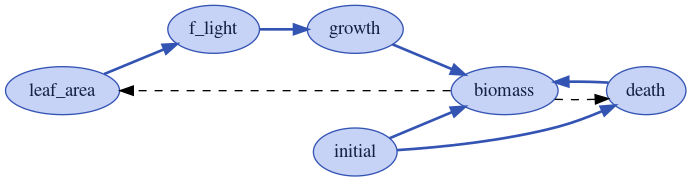

In [4]:
model.visualize()

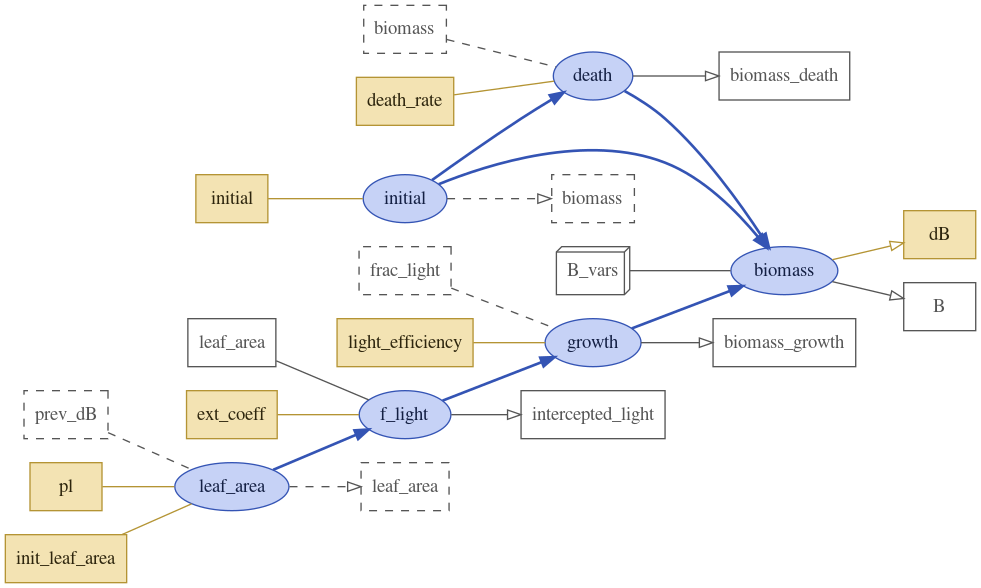

In [5]:
model.visualize(show_variables=True)

In [6]:
ds_in = xs.create_setup(model=model,clocks={'clock':range(100)},output_vars={'biomass__B':'clock'})

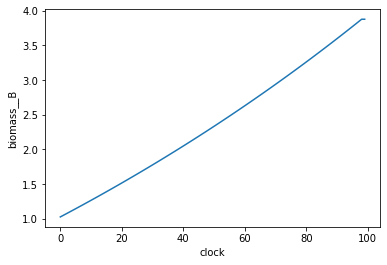

In [7]:
#plot to verify that it works
ds_in.xsimlab.run(model).biomass__B.plot()